In [1]:
# Imports

import os
import joblib
import pandas as pd

from src.modsec import init_modsec
from src.utils import load_data_label_vector, get_most_recent_data_path
from src.model import train_model, test_evasion
from config import BaseConfig, HalfConfig, PaperConfig

In [2]:
# Setup Variables

Config = PaperConfig()
data_path = get_most_recent_data_path()

print(f"Using data from {data_path}")

Using data from data/prepared/2024-03-27-17-50-15


In [3]:
# Load Data

train = load_data_label_vector(f"{data_path}/train.csv")
test = load_data_label_vector(f"{data_path}/test.csv")
train_adv = load_data_label_vector(f"{data_path}/train_adv.csv")
test_adv = load_data_label_vector(f"{data_path}/test_adv.csv")

# print shape
print(f"Train: {train.shape}, Test: {test.shape}")
print(f"Train Adv: {train_adv.shape}, Test Adv: {test_adv.shape}")

Train: (20000, 3), Test: (4000, 3)
Train Adv: (5000, 3), Test Adv: (2000, 3)


Model trained successfully!
Evaluating model...
Default threshold: 0.5
FRP is currently at 0.0172
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2000
           1       0.98      0.96      0.97      4000

    accuracy                           0.96      6000
   macro avg       0.95      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



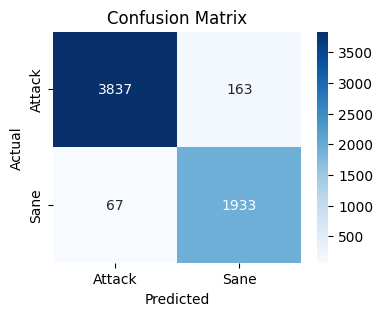

Adjusting threshold to match desired FPR of 0.01


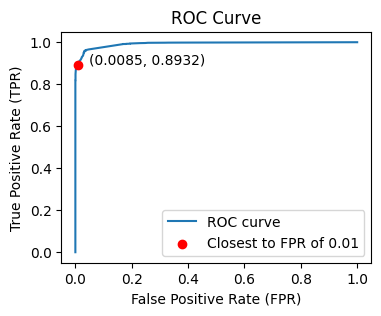

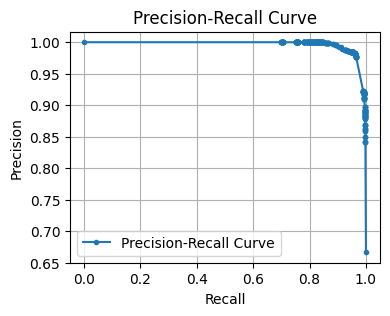

Adjusted threshold: 0.847 with FPR of 0.0085 (closest to desired FPR 0.01)
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      2000
           1       1.00      0.89      0.94      4000

    accuracy                           0.93      6000
   macro avg       0.91      0.94      0.92      6000
weighted avg       0.94      0.93      0.93      6000



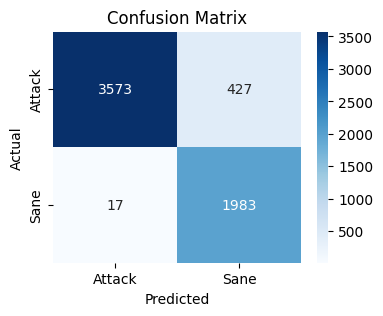

In [4]:
# Load/Train Models

model_trained = joblib.load(f"{data_path}/model.joblib")
threshold = float(open(f"{data_path}/threshold.txt", "r").read())

model_adv_trained, threshold_adv = train_model(
    train=pd.concat([train, train_adv]).sample(frac=1).reset_index(drop=True),
    test=pd.concat([test, test_adv]).sample(frac=1).reset_index(drop=True),
    model=Config.MODEL_ADV,
    desired_fpr=Config.DESIRED_FPR,
)

In [5]:
# Test Evasion (base model without adversarial training)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_trained,
    engine_eval_settings={
        "max_rounds": 2000,
        "round_size": 30,
        "timeout": 120,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 1.0
[!] Execution timed out
Reached confidence 0.789461749298735
with payload
'sELeCt\tSLEEP((seLECt/*!*/0x5))#";0x3\\[V'
Min payload: b'sELeCt\tSLEEP((seLECt/*!*/0x5))#";0x3\\[V'
Min confidence: 0.78946
Reduced confidence from 1.0 to 0.78946 (reduction of 0.21054)

Evasion successful


In [6]:
# Test Evasion (adversarially trained model)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_adv_trained,
    engine_eval_settings={
        "max_rounds": 2000,
        "round_size": 30,
        "timeout": 120,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 0.99552
[!] Execution timed out
Reached confidence 0.9397182587149693
with payload
'SElECT\x0bSLEEP(0x5)#";.0x5\xa0/F'
Min payload: b'SElECT\x0bSLEEP(0x5)#";.0x5\xc2\xa0/F'
Min confidence: 0.93972
Reduced confidence from 0.99552 to 0.93972 (reduction of 0.0558)
Evasion failed
